In [85]:
#todo: Look into seaborn https://seaborn.pydata.org
# especially for coloring and style
from astropy.io import fits
import astropy.wcs as wcs
from astropy.nddata import CCDData
from astropy.table import Table
import astropy.units as u
from astropy.nddata import NDDataArray, StdDevUncertainty, NDUncertainty, VarianceUncertainty, InverseVariance
from astropy.visualization import simple_norm
from astropy.utils.decorators import sharedmethod

import numpy as np
import scipy.stats as stats
from skimage import data, exposure
#import pandas as pd
#import aplpy
import itertools
import collections
from copy import deepcopy

import matplotlib.pyplot as plt
import matplotlib.colors as mpcolors
from matplotlib import ticker
from matplotlib.lines import Line2D

%matplotlib inline

# Mathematical Steps
For a given spatial pixel $p = (x,y)$ with $N$ values of observed line ratios $R_N(p)$ with errors on the line ratios $E_N(p)$ in same units as $R_N$, we use predicted line ratios as function of $A_N(G_0,n)$, to compute differences $\delta_N$ across all $A$:
$${\delta_N^2(p,G_0,n)} = {\left[ R_N(p) - A_N(G_0,n)\over E_N(x)\right] }^2$$
 
The reduced chi-squared for spatial pixel $i$ is then given by

$$\chi^2(p,G_0,n) =  \sum_N {\delta_N^2(p,G_0,n) \over N-1}$$

and the best-fit value of $(G_0,n)$ is the minimum of $\chi^2$  The range of $(G_0,n)$ over which $A_N$ have been computed must be large enough to encompass physically reasonable values in the ISM, typically $10^{-1} < G_0 < 10^7$ in Habing units and $1 < n < 10^7$ cm$^{-3}$

For a spatial map, we do the above computation over all $p$ to produce a spatial maps of $\chi^2$ and best-fit spatial maps of $(G_0,n)$.

# Logical Steps
Given a list of measurement IDs,
1. Find all available matching model ratios
2. For each matching model ratio, compute the corresponding measurement ratios (including error propagation)
3. For each measurement ratio, compute the $\delta^2$ as above, using the ratio label as in index to find the corresponding FITS file of $A(G_0,n)$.
4. Compute $\chi^2$ from the $\delta$'s as above.
    

In [86]:
# maybe this is just better storing this info in a Table.  Then adding models is 
# just adding to the table
class ModelRatioData:
    def __init__(self,numerator, denominator, identifier,filename,metallicity=1):
        self._numerator = numerator
        self._denominator =denominator
        self._identifier = identifier
        self._filename = filename + "web"
        self._metallicity= metallicity
        
    @property
    def id(self): return self._identifier

    @property 
    def filename(self): return self._filename
    
    @property 
    def metallicity(self): return self._metallicity
    
    @property
    def isSolarMetallicity(self):
        return self._metallicity == 1
#-------------------------------------------------------------------------------    
# arithmetic based on CCD data -- did not solve the bug    
def _arithmetic(op):
    """Decorator factory which temporarly disables the need for a unit when
    creating a new CCDData instance. The final result must have a unit.

    Parameters
    ----------
    op : function
        The function to apply. Supported are:

        - ``np.add``
        - ``np.subtract``
        - ``np.multiply``
        - ``np.true_divide``

    Notes
    -----
    Should only be used on CCDData ``add``, ``subtract``, ``divide`` or
    ``multiply`` because only these methods from NDArithmeticMixin are
    overwritten.
    """
    def decorator(func):
        def inner(self, operand, operand2=None, **kwargs):
            print("doing arithmetic")
            result = self._prepare_then_do_arithmetic(op, operand,
                                                      operand2, **kwargs)
            return result.__class__(result)
        inner.__doc__ = ("See `astropy.nddata.NDArithmeticMixin.{}`."
                         "".format(func.__name__))
        return sharedmethod(inner)
    return decorator

def _uncertainty_unit_equivalent_to_parent(uncertainty_type, unit, parent_unit):
    if uncertainty_type is StdDevUncertainty:
        return unit == parent_unit
    elif uncertainty_type is VarianceUncertainty:
        return unit == (parent_unit ** 2)
    elif uncertainty_type is InverseVariance:
        return unit == (1 / (parent_unit ** 2))
    raise ValueError("unsupported uncertainty type: {}"
                     .format(uncertainty_type))
    

class Measurement0(NDDataArray):
    def __init__(self,*args, **kwargs):
        self._identifier = kwargs.pop('identifier', None)
        super().__init__(*args, **kwargs)
    
    @property
    def id(self): return self._identifier
    
    add = _arithmetic(np.add)(NDDataArray.add)
    subtract = _arithmetic(np.subtract)(NDDataArray.subtract)
    multiply = _arithmetic(np.multiply)(NDDataArray.multiply)
    divide = _arithmetic(np.true_divide)(NDDataArray.divide)
#-------------------------------------------------------------------------------         
    
class Measurement(NDDataArray):
    '''Measurement represents one or more observations of a given spectral line or continuum. 
       It is made up of a value array, an uncertainty array, units, and a string identifier
       It is based on astropy's NDDataArray.   Mathematical operations using Measurements
       will correctly propogate errors.
       
    Parameters
    -----------
    data :  `numpy.ndarray`-like
        The actual data contained in this `Measurement` object.
        Note that the data will always be saved by *reference*, so you should
        make a copy of the ``data`` before passing it in if that's the desired
        behavior.
        
    identifier  : string indicating what this is an observation of, e.g. "CO(1-0)"
    
    uncertainty : `~astropy.nddata.StdDevUncertainty`, \
            `~astropy.nddata.VarianceUncertainty`, \
            `~astropy.nddata.InverseVariance`, `numpy.ndarray` or 
        Uncertainties on the data. If the uncertainty is a `numpy.ndarray`, it
        it assumed to be, and stored as, a `~astropy.nddata.StdDevUncertainty`.
        Required.

    unit : `~astropy.units.Unit` or str, optional
        The units of the data.
        Default is "adu" (arbitrary data units).
        
       @todo: replace NDDataArray with CCDData.
    '''
    def __init__(self,*args, **kwargs):
        self._identifier = kwargs.pop('identifier', None)
        self._units = kwargs.pop('units', 'adu')
        super().__init__(*args, **kwargs)
        
    @property
    def flux(self):
        '''Return the underlying flux data array'''
        return self.data
    
    @property
    def id(self):
        '''Return the string ID of this measurement, e.g. "CO(1-0)""'''
        return self._identifier
    
    @property
    def error(self):
        '''Return the underlying error array'''
        return self.uncertainty._array
      
    def add(self,other):
        '''Add this Measurement to another, propagating errors and updating identifiers'''
        z=super().add(other)
        z._identifier = self.id + '+' + other.id
        return z
   
    def subtract(self,other):
        '''Subtract another Measurement from this one, propagating errors and updating identifiers'''
        z=super().subtract(other)
        z._identifier = self.id + '-' + other.id
        return z
    
    def multiply(self,other):
        '''Multiply this Measurement by another, propagating errors and updating identifiers'''
        #zz = super()
        #print(type(zz))
        z=super().multiply(other)
        #print(self.id,other.id)
        z._identifier = self.id + '*' + other.id
        return z
        
    def divide(self,other):
        '''Divide this Measurement by another, propagating errors and updating identifiers'''
        #zz = super()
        #print(type(zz))
        z=super().divide(other)
        #print(self.id,other.id)
        z._identifier = self.id + '/' + other.id
        return z
    
    def __add__(self,other):
        '''Add this Measurement to another using + operator, propagating errors and updating identifiers'''
        z=self.add(other)
        return z
    def __sub__(self,other): 
        '''Subtract another Measurement from this one using - operator, propagating errors and updating identifiers'''
        z=self.subtract(other)
        return z
    
    def __mul__(self,other):
        '''Multiply this Measurement by another using * operator, propagating errors and updating identifiers'''
        z=self.multiply(other)
        return z
    
    def __truediv__(self,other):
        '''Divide this Measurement by another using / operator, propagating errors and updating identifiers'''
        z=self.divide(other)
        return z
    
class PDRutils:
    def __init__(self,models,measurements=None):
        if type(models) == str:
            self.initializeFromFile(models)
        else:
            self._models = models
        self._measurements = measurements
        # todo: store model file data rather than re-read everytime
        self._fitsfiles = None
        self._modelfiles = None
        self._ratios = None
        self._chisq = None
        self._deltaSq = None
        self._reduceChisq = None
    
    def _addMeasurement(self,m):
        pass
    
    def _removeMeasurement(self,m):
        pass
    
    def addObservation(self,m):
        # m can be Measurement or MeasurementImage (CCDData+uncertainty+label)
        pass
        
    def makeDefaultTable(self):
        ratiodict = {
        "OI_145/OI_63"   : "oioi",
        "OI_145/CII_158" : "o145cii",
        "OI_63/CII_158"  : "oicp",
        "CII_158/CI_609" : "ciici609",
        "CI_370/CI_609"  : "cici",
        "CII_158/CO_10"  : "ciico",
        "CI_609/CO_10"   : "cico",
        "CI_609/CO_21"   : "cico21",
        "CI_609/CO_32"   : "cico32",
        "CI_609/CO_43"   : "cico43",
        "CI_609/CO_54"   : "cico54",
        "CI_609/CO_65"   : "cico65",
        "CO_21/CO_10"    : "co2110",
        "CO_32/CO_10"    : "co3210",
        "CO_32/CO_21"    : "co3221",
        "CO_43/CO_21"    : "co4321",
        "CO_65/CO_10"    : "co6510",
        "CO_65/CO_21"    : "co6521",
        "CO_65/CO_54"    : "co6554",
        "CO_76/CO_10"    : "co7610",
        "CO_76/CO_21"    : "co7621",
        "CO_76/CO_43"    : "co7643",
        "CO_76/CO_54"    : "co7654",
        "CO_76/CO_65"    : "co7665",
        "CO_87/CO_54"   : "co8754",
        "CO_87/CO_65"   : "co8765",
        "CO_98/CO_54"   : "co9854",
        "CO_98/CO_65"   : "co9865",
        "CO_109/CO_54"   : "co10954",
        "CO_109/CO_65"   : "co10965",
        "CO_1110/CO_54"   : "co111054",
        "CO_1110/CO_65"   : "co111065",
        "CO_1211/CO_54"   : "co121154",
        "CO_1211/CO_65"   : "co121165",
        "CO_1312/CO_54"   : "co131254",
        "CO_1312/CO_65"   : "co131265",
        "CO_1413/CO_54"   : "co141354",
        "CO_1413/CO_65"   : "co141365",
        "OI_63+CII_158/FIR"     : "fir",
        "OI_145+CII_158/FIR"  : "firoi145",
        "SIII_Z1/FEII_Z1"  : "siii35feii26z1",
        "SIII_Z3/FEII_Z3"  : "siii35feii26z3",
        "H200S1_Z1/H200S0_Z1" : "h200s1s0z1",
        "H200S1_Z3/H200S0_Z3" : "h200s1s0z3",
        "H200S2_Z1/H200S0_Z1" : "h200s2s0z1",
        "H200S2_Z3/H200S0_Z3" : "h200s2s0z3",
        "H200S2_Z1/H200S1_Z1" : "h200s2s1z1",
        "H200S2_Z3/H200S1_Z3" : "h200s2s1z3",
        "H200S3_Z1/H200S1_Z1" : "h200s3s1z1",
        "H200S3_Z3/H200S1_Z3" : "h200s3s1z3",
        "H200S1_Z1/SIII_Z1" : "h200s1siiiz1",
        "H200S1_Z3/SIII_Z3" : "h200s1siiiz3",
        "H200S2_Z1/SIII_Z1" : "h200s2siiiz1",
        "H200S2_Z3/SIII_Z3" : "h200s2siiiz3",
        "H264Q1_Z1/H210S1_Z1" : "h264q110s1z1",
        "H264Q1_Z3/H210S1_Z3" : "h264q110s1z3"
        }
        a = list()
        b = list()
        for r in ratiodict:
            nd = r.split("/")
            if ("Z3" in r):
                z=3
            else:
                z=1
            b.append((nd[0],nd[1],r,ratiodict[r]+"web",z))
            a.append(ModelRatioData(nd[0],nd[1],r,ratiodict[r],z))
        t = Table(rows=b,names=("numerator","denominator","label","filename","z"))
        t.add_index("label")
        t.write("current_models.tab",format="ascii.ipac",overwrite=True)
  
    def initializeFromFile(self,filename):
        """initialize models from an IPAC format ASCII file"""
        # Todo: add LaTeX labels as a column for more stylish plotting
        self._models=Table.read(filename,format="ascii.ipac")
        self._models.add_index("label")
        
    def supportedLines(self):
        '''Return a `set` of lines and continuum recognized by this class (i.e., that have been modeled by us)'''
        return set(np.append(self._models["numerator"].data,self._models["denominator"].data))

    def find_ratio_elements(self,m):
        """Return an iterator of valid numerator,denominator pairs in 
        dict format for the given list of measurement IDs
        """
        if not isinstance(m, collections.abc.Iterable) or isinstance(m, (str, bytes)) :
            raise Exception("m must be an array of strings")
            
        for q in itertools.product(m,m):
            s = q[0]+"/"+q[1]
            z = dict()
            if s in self._models["label"]:
                z={"numerator":self._models.loc[s]["numerator"],
                   "denominator":self._models.loc[s]["denominator"]}
                yield(z)
                
    def get_ratio_elements(self,m):   
        """Return a list of valid numerator,denominator pairs in dict format for the 
        given list of measurement IDs
        """
        if not isinstance(m, collections.abc.Iterable) or isinstance(m, (str, bytes)) :
            raise Exception("m must be an array of strings")
        k = list()   
        for q in itertools.product(m,m):
            s = q[0]+"/"+q[1]
            if s in self._models["label"]:
                z={"numerator":self._models.loc[s]["numerator"],
                   "denominator":self._models.loc[s]["denominator"]}
                k.append(z)
                
        return k
                 
    def find_pairs(self,m):
        """Return an iterator of model ratios labels for the given list of measurement IDs"""
        if not isinstance(m, collections.abc.Iterable) or isinstance(m, (str, bytes)) :
            raise Exception("m must be an array of strings")
            
        for q in itertools.product(m,m):
            s = q[0]+"/"+q[1]
            if s in self._models["label"]:
                yield(s)
    
    def find_files(self,m,ext="fits"):
        """Return an iterator of model ratio files for the given list of measurement IDs"""
        if not isinstance(m, collections.abc.Iterable) or isinstance(m, (str, bytes)):
            raise Exception("m must be an array of strings")
        for q in itertools.product(m,m):
            s = q[0]+"/"+q[1]
            if s in self._models["label"]:
                tup = (s,self._models.loc[s]["filename"]+"."+ext)
                #yield(self._models.loc[s]["filename"]+"."+ext)
                yield(tup)
                
    def setModelfiles(self,m):
        self._modelfiles = dict()
        for x in self.find_files(m):
            self._modelfiles[x[0]]=x[1]
            
    def ratiocount(self,m):
        """Return the number of model ratios found for the given list of measurement IDs"""
        # since find_files is a generator, we can't use len(), so do this sum.
        # See https://stackoverflow.com/questions/393053/length-of-generator-output
        return(sum(1 for _ in self.find_files(m)))
                
    def read_fits(self,m):
        """Given a list of measurement IDs, find and open the FITS files that have matching ratios
           and populate the _fitsfiles dictionary
        """
        d = "/n/lupus/mpound/WITS/Docs/pdrt/"
        self._fitsfiles = dict()
        for (k,p) in self.find_files(m):
            self._fitsfiles[k] = fits.open(d+p)
            
    def read_ccd(self,m,unit):
        """Test method to use astropy's CCDdata as a storage mechanism for our model 
           ratio or observer data FITS files.
            Parameters: 
                 m - list of measurement IDS (string)
                 unit - units of the data (string)
        """
        d = "/n/lupus/mpound/WITS/Docs/pdrt/"
        self._fitsfiles = dict()
        for (k,p) in self.find_files(m):
            self._fitsfiles[k] = CCDData.read(d+p,unit=unit)
    
    def doit(self,measurements):
        #measurements is a dict
        mids = measurements.keys()
        #self.read_fits(mids)
        self.read_ccd(mids,unit='adu')
        self.computeValidRatios(measurements)
        self.computeDeltaSq(mids)
        self.computeChisq()
        #self.plotChisq()
      
    def computeValidRatios(self,measurements):
        z = self.find_ratio_elements(measurements.keys())
        self._ratios = dict()
        for p in z:
            label = p["numerator"]+"/"+p["denominator"]
            # deepcopy workaround for bug: https://github.com/astropy/astropy/issues/9006
            self._ratios[label] = deepcopy(measurements[p["numerator"]])/deepcopy(measurements[p["denominator"]])
        
    
    def computeDeltaSq(self,measurements):
        #@todo perhaps don't store _fitsfiles but have them be a return value of read_fits.
        # reasoning is that if we use the same PDRUtils object to make multiple computations, we
        # have to be careful to clear _fitsfiles each time.
        
        if not self._fitsfiles: # empty list or None
            raise Exception("No model data ready.  You need to call read_fits")
        
        self._deltasq = dict()
        for r in self._ratios:
            _z = self._fitsfiles[r].multiply(-1.0)
            _z._data = _z._data + self._ratios[r].flux
            _q = _z.divide(self._ratios[r].error)
            self._deltasq[r] = _q.multiply(_q)
        
    def computeChisq(self):
        sumary = sum((self._deltasq[r]._data for r in self._deltasq))
        self._dof = len(self._deltasq) - 1
        k = list(self._deltasq.keys())[0]
        self._chisq = CCDData(sumary,unit='adu',wcs=self._deltasq[k].wcs)
        self._reducedChisq =  self._chisq.divide(self._dof)
        
    def plotReducedChisq(self,cmap='plasma',image=True, contours=True,levels=None,measurements=None):
        file="rchisq.fits"
        self._reducedChisq.write(file,overwrite=True)
        self._plot(file,cmap,image, contours,levels,measurements)
        
    def plotChisq(self,cmap='plasma',image=True, contours=True, levels=None, measurements=None):
        file="chisq.fits"
        self._chisq.write(file,overwrite=True)
        self._plot(file,cmap,image, contours,levels,measurements)
       
    def _plot(self,file,cmap, image, contours, levels, measurements):
        # todo: use stored fits file data rather than re-read everytime
        k = fits.open(file)[0]
        min_ = k.data.min()
        max_ = k.data.max()
        ax=plt.subplot(111)
        ax.set_aspect('equal')
        normalizer = simple_norm(k.data, min_cut=min_,max_cut=max_, stretch='log', clip=False)
        xstart=k.header['crval1']
        xstop=xstart+k.header['naxis1']*k.header['cdelt1']
        ystart=k.header['crval2']
        ystop=ystart+k.header['naxis2']*k.header['cdelt2']
        #print(xstart,xstop,ystart,ystop)
    
        y = 10**np.linspace(start=ystart, stop=ystop, num=k.header['naxis2'])
        x = 10**np.linspace(start=xstart, stop=xstop, num=k.header['naxis1'])
        ax.set_xscale('log')
        ax.set_yscale('log')
        #if True:
        #    chihist = exposure.equalize_hist(k.data)
        #    ax.pcolormesh(x,y,chihist,cmap=cmap)
        if image:
            ax.pcolormesh(x,y,k.data,cmap=cmap,norm=normalizer)
        
        locmaj = ticker.LogLocator(base=10.0, subs=(1.0, ),numticks=10)
        ax.xaxis.set_major_locator(locmaj)
        locmin = ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1,numticks=10) 
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(ticker.NullFormatter())
        #todo: allow unit conversion to cgs or Draine
        ylab = 'Log($G_0$) [Habing]'
        ss = 'Log($P_{th}/k$) [cm$^{-2}$]'
        xlab = 'Log(n) [cm$^{-3}$]'
        ax.set_ylabel(ylab)
        ax.set_xlabel(xlab)

        if contours:
            if image==False: colors='black'
            else: colors='white'
            if levels == None:
                # Figure out some autolevels 
                # ------------------------------------------
                #  below resulted in poorly spaced levels
                # ------------------------------------------
                #if ( max_ - min_ ) < 101.0:
                #    steps = 'lin'
                #else:
                #    steps = 'log'
                # ------------------------------------------
                steps='log'
                contourset = ax.contour(x,y,k.data, levels=self._autolevels(k.data,steps),colors=colors)
            else:
                contourset = ax.contour(x,y,k.data, levels=levels, colors=colors)
                # todo: add contour level labelling
                # See https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/contour_label_demo.html
        if measurements:
            for m in measurements:
            #todo: use matplotlib contourf to shade the area between +/- error rather than use dashed lines
                conts = [m.flux-m.error, m.flux, m.flux+m.error]
                lstyles = ['--','-','--']
                colors = [self._ratiocolor,self._ratiocolor,self._ratiocolor]
                for i in range(0,3):
                    cset = ax.contour(x,y,k.data,levels=conts,linestyles=lstyles,
                                      colors=colors)
                
    def getBestnG0(self):
        if self._chisq == None: return [None,None]
        min_ary = np.flip(divmod(p._reducedChisq.data.argmin(),p._chisq.data.shape[1]))+1
        print("min indices (n,G0) = ",min_ary)
        h = fits.open("chisq.fits")[0].header
        logn = h['crval1']+(min_ary[0]-h['crpix1'])*h['cdelt1']
        logg0 = h['crval2']+(min_ary[1]-h['crpix2'])*h['cdelt2']
        g0 = 10.0**logg0
        n  = 10.0**logn
        return [n,g0]
        
    def plotConfidenceIntervals(self,image=True, cmap='plasma',contours=True,levels=None,reduced=False):
        if reduced:  chi2_stat = stats.distributions.chi2.cdf(self._reducedChisq.data,self._dof)
        else:       chi2_stat = stats.distributions.chi2.cdf(self._chisq.data,self._dof)
        normalizer = simple_norm(chi2_stat, stretch='log', clip=False)
        if image: plt.imshow(chi2_stat*100,aspect='equal',cmap=cmap,norm=normalizer)
        print(100*chi2_stat.min(),100*chi2_stat.max())
        if contours:
            if levels==None:
                levels = [68.,80., 95., 99.]
            plt.contour(chi2_stat*100,colors='black',levels=sorted(levels))
    
    def plotRatiosOnModels(self):
        CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
        i =0 
        for x in self._modelfiles:
            self._ratiocolor = CB_color_cycle[i]
            self._plot('models/'+self._modelfiles[x],cmap='plasma',
                       measurements=[p._ratios[x]],image=False,contours=False,levels=None)
            i = i+1
        # do some sort of legend
        lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in CB_color_cycle[0:i]]
        labels = list(self._modelfiles.keys())
        plt.legend(lines, labels)
        plt.show()

    def makeRatioOverlays(self,cmap='plasma'):
        for x in self._modelfiles:
            #self._ratiocolor='silver'
            self._ratiocolor='#4daf4a'
            self._plot('models/'+self._modelfiles[x],cmap=cmap,
                       measurements=[p._ratios[x]],image=True,contours=True,levels=None)
            plt.title(x)
            plt.show()
            plt.clf()
            
    def _autolevels(self,data,steps='log',numlevels=None):
        # tip of the hat to the WIP autolevels code lev.
        # http://admit.astro.umd.edu/wip ,  wip/src/plot/levels.c
        # CVS at http://www.astro.umd.edu/~teuben/miriad/install.html
        max_ =data.max()
        min_ = data.min()
        if numlevels == None:
            numlevels = int(0.5+3*(np.log(max_)-np.log(min_))/np.log(10))
        #print("levels start %d levels"%numlevels)
        # force number of levels to be between 5 and 15
        numlevels = max(numlevels,5)
        numlevels = min(numlevels,15)
    
        #print("Autolevels got %d levels"%numlevels)
        if steps[0:3] == 'lin':
            slope = (max_ - min_)/(numlevels-1)
            levels = np.array([min_+slope*j for j in range(0,numlevels)])
        elif steps[0:3] == 'log':
            # if data minimum is non-positive (shouldn't happen for models),
            # start log contours at lgo10(1) = 0
            if min_ <= 0: min_=1
            slope = np.log10(max_/min_)/(numlevels - 1)
            levels = np.array([min_ * np.power(10,slope*j) for j in range(0,numlevels)])
        else:
           raise Exception("steps must be 'lin' or 'log'")
        return levels
        
    
    #def plotChisq2(self,cmap='plasma',contours=True,levels=None):
    #    self._chisq.write("chisq.fits",overwrite=True)
    #    min_ = self._chisq.data.min()
    #    max_ = self._chisq.data.max()
     #   gc.show_colorscale(cmap=cmap,vmin=min_, vmax=max_,stretch='log')
    #    gc.axis_labels.set_ytext('Log($G_0$) [Habing]')
    #    gc.axis_labels.set_xtext('Log(n) [cm$^{-3}$] ')
     #   if contours:
    #        if levels == None:
    #            levels_ = np.array([2.,6.,12.,18.])*min_
    #            gc.show_contour(colors='white',levels=levels_)
     #       else:
     #           gc.show_contour(colors='white',levels=levels)
    
    def testme(self,min_,max_,numlevels):
        minsv = None
        if min_ < 0: 
            minsv = min_
            max_ = max_ + 1 - min_
            min_ = 1
        slope = np.log10(max_/min_)/(numlevels -1 )
        levels = np.array([min_ * np.power(10,slope*j) for j in range(0,numlevels)])
        print(levels)
        if minsv: 
            print("shift is ",(-1 - np.log10(np.abs(minsv))))
            levels = levels - 1 - np.log10(np.abs(minsv))
            print(levels)

                

In [87]:
m1 = Measurement(data=30.,uncertainty = StdDevUncertainty(5.),identifier="OI_145")
m2 = Measurement(data=10.,uncertainty = StdDevUncertainty(2.),identifier="CI_609")
m3 = Measurement(data=10.,uncertainty = StdDevUncertainty(1.5),identifier="CO_21")
m4 = Measurement(data=100.,uncertainty = StdDevUncertainty(10.),identifier="CII_158")
m = [m1.id,m2.id,m3.id,m4.id]
md = dict()
for t in [m1,m2,m3,m4]:
    md[t.id] = t
#print(md)
#m1.__dict__

In [88]:
p = PDRutils("current_models.tab")
#m = pd.Series([m1.id,m2.id,m3.id,m4.id])
m = [m1.id,m2.id,m3.id,m4.id]
p.ratiocount(m)
#x = p.get_ratio_elements(m)
#print(x)
if False:
    for _z in p.find_ratio_elements(m):
        # we are forced to make a deep copy here otherwise an attribute error is raised.
        # See https://github.com/astropy/astropy/issues/9006
       _m1 = deepcopy(md[_z["numerator"]])
       _m2 = deepcopy(md[_z["denominator"]])
       #m3 = md[x[xx]["numerator"]]/md[x[xx]["denominator"]]
       _m3=_m1/(_m2)
       print("u=",_m3.uncertainty)


In [89]:
p.doit(md)

TypeError: unsupported operand type(s) for /: 'Measurement' and 'Measurement'

In [90]:
plt.style.use('default')
#plt.style.available
p.plotChisq(image=False)
#p.plotConfidenceIntervals(cmap='gray',levels=[68,75,95,99],image=True)

AttributeError: 'NoneType' object has no attribute 'write'

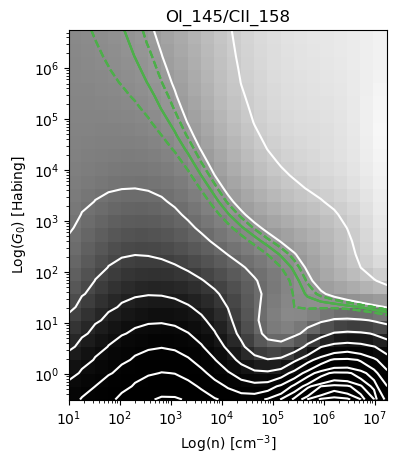

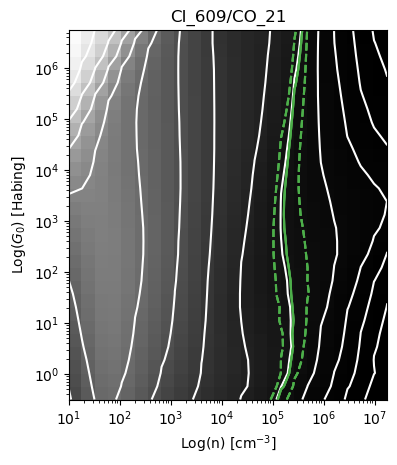

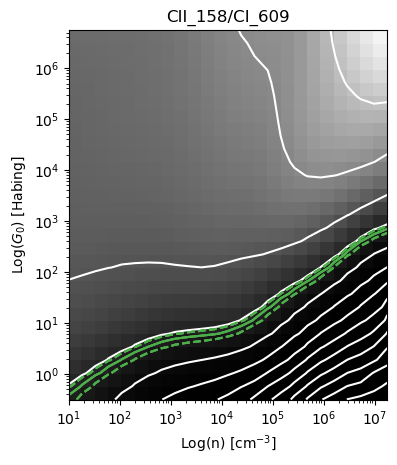

<Figure size 640x480 with 0 Axes>

In [84]:
p.get_ratio_elements(md)
p._ratios

#p._plot("models/o145ciiweb.fits",cmap='plasma',measurements=[p._ratios['OI_145/CII_158']],image=True,contours=True,levels=None)
#p.getBestnG0()
#p._reducedChisq.shape
#p._reducedChisq.data.min()
#plt.subplots(nrows=1,ncols=len(p._ratios))
p.setModelfiles(md)
p.makeRatioOverlays(cmap='gray')

#for x in p.find_files(md):
#    p._plot('models/'+x[1],cmap='plasma',measurements=[p._ratios[x[0]]],image=True,contours=True,levels=None)
#    plt.title(x[0])
#    plt.show()
#    plt.clf()

/n/algol2/mpound/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:385: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


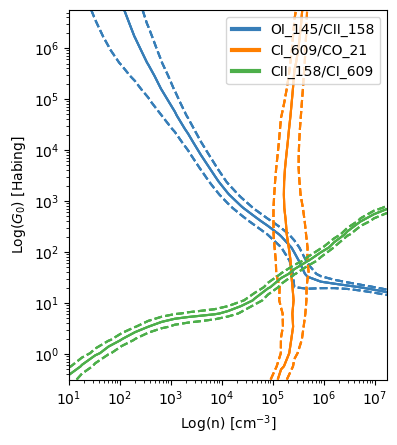

In [63]:
p.setModelfiles(md)
p.plotRatiosOnModels()

In [ ]:
np.shape(p._chisq)
np.argwhere(p._chisq.data == np.min(p._chisq.data))[0]
divmod(p._chisq.data.argmin(),p._chisq.data.shape[1])
p._chisq.data[18,7]/3

In [ ]:
x = CCDData.read("/lupus/mpound/WITS/Docs/pdrt/co7610webpth.fits",unit='adu')
z = fits.open("/lupus/mpound/WITS/Docs/pdrt/co7610webpth.fits")

In [ ]:
 print(plt.style.available)

In [ ]:
plt.style.use('seaborn-poster')
k=z[0]
#k.verify('fix')
print(wcs.find_all_wcs(k.header))
#wcs.validate("/lupus/mpound/WITS/Docs/pdrt/co7610webpth.fits")
k.header

In [ ]:


mywcs = wcs.WCS(k.header)
fig, (ax,ax2) = plt.subplots(ncols=2)#,projection=mywcs)
#ax=plt.subplot(121,projection=mywcs)
#ax2=plt.subplot(122)
ax.imshow(k.data,cmap='plasma',aspect="auto",extent=(100,10**7.25,10*-0.5,10**8.25))
ax.set_xscale('log')
ax.set_yscale('log')
xstart=k.header['crval1']
xstop=xstart+k.header['naxis1']*k.header['cdelt1']
ystart=k.header['crval2']
ystop=ystart+k.header['naxis2']*k.header['cdelt2']
print(xstart,xstop,ystart,ystop)
#stop=k.header[]
y = 10**np.linspace(start=ystart, stop=ystop, num=k.header['naxis2'])
x = 10**np.linspace(start=xstart, stop=xstop, num=k.header['naxis1'])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.pcolormesh(x,y,k.data,cmap='plasma')
#ax2.autoscale('tight')
locmaj = ticker.LogLocator(base=10.0, subs=(1.0, ),numticks=10)
ax2.xaxis.set_major_locator(locmaj)
locmin = ticker.LogLocator(base=10.0, subs=np.arange(2, 10)*.1,numticks=10) 
ax2.xaxis.set_minor_locator(locmin)
ax2.xaxis.set_minor_formatter(ticker.NullFormatter())
s = 'Log($G_0$) [Habing]'
ss = 'Log($P_{th}/k$) [cm$^{-2}$]'
ax.set_ylabel(s)
ax2.set_ylabel(s)
ax.set_xlabel(ss)
ax2.set_xlabel(ss)

#ax2.xaxis.get_major_locator().set_params(base=10.,subs='all')
#ax2.xaxis.get_minor_locator().set_params(subs='all',numticks=9)

#ax2.yaxis.get_major_locator().set_params(base=10.,subs='all')
#ax2.yaxis.get_minor_locator().set_params(base=10.,subs='all',numticks=9)
#ax2.yaxis.get_major_locator().set_params(base=10,subs='all')
#ax2.grid()
print(ax2.get_xticks())
#print(ax2.xaxis.get_minor_locator()())
plt.show()


In [ ]:
k=z[0]
k.verify('fix')
print(wcs.find_all_wcs(k.header))
print(k.header
wcs.validate("/lupus/mpound/WITS/Docs/pdrt/co7610webpth.fits")
mywcs = wcs.WCS(k.header)
fig, (ax,ax2) = plt.subplots(ncols=2)#,projection=mywcs)
#ax=plt.subplot(121,projection=mywcs)
#ax2=plt.subplot(122)
ax.imshow(k.data,cmap='plasma',aspect="auto",extent=(100,10**7.25,10*-0.5,10**8.25))
#ax.loglog()
xstart=k.header['crval1']
xstop=start+k.header['naxis1']*k.header['cdelt1']
ystart=k.header['crval2']
ystop=start+k.header['naxis2']*k.header['cdelt2']
print(xstart,xstop,ystart,ystop)
#stop=k.header[]
y = 10**np.linspace(start=ystart, stop=ystop, num=k.header['naxis2'])
x = 10**np.linspace(start=xstart, stop=xstop, num=k.header['naxis1'])
ax2.pcolormesh(x,y,k.data,cmap='gray_r')
ax2.loglog()

#ax2.set_yscale('log')
#ax2.set_xscale('log')
plt.show()

In [ ]:
tt = p._chisq
print(tt.wcs)
plt.imshow(tt,norm=mpcolors.LogNorm(vmin=tt.data.min(), vmax=tt.data.max()),cmap='hsv_r',origin='lower')

In [ ]:
p.read_ccd(m,unit='flx')
#print(p._fitsfiles['OI_145/CII_158'])
#_z=p._fitsfiles['OI_145/CII_158'].multiply(-1.0).divide(2.0)
#print(p._fitsfiles)
#print(_z)
p.computeValidRatios(md)
#for x in p.find_files(m):
#    print(x)
#print(p._ratios['OI_145/CII_158'].error)
p.computeDeltaSq(md)
print(type(p._deltasq['OI_145/CII_158']._data))
for item in p._deltasq:
    print(item)
#sum(p._deltasq[item]._data for item in p._deltasq)
len(p._deltasq)
p.computeChisq()

In [ ]:
np.min(p._chisq.data)

In [ ]:
t = CCDData.read("chisqweb.fits",unit="flx")
print(t.wcs)

In [ ]:
np.min(t.data)
print(t.data.shape)
print(t.wcs.__dict__)
print(t.wcs.wcs.cdelt)

In [ ]:
#ax=plt.subplot(xlim=[t.wcs.wcs.crval[0],t.wcs._naxis[0]*t.wcs.wcs.cdelt[0]],ylim=[t.wcs.wcs.crval[1],t.wcs._naxis[1]*t.wcs.wcs.cdelt[1]])
ax=plt.subplot()
ax.imshow(t.data,norm=mpcolors.LogNorm(vmin=t.data.min(), vmax=t.data.max()),cmap='hsv_r',origin='lower')
ax.loglog()
ticks=ax.get_xticks()
print(ticks)#ax.loglog(

In [ ]:
k = fits.open("chisq.fits")
k[0].data = k[0].data - 20.0
k.writeto("test.fits")

In [ ]:
for f in p._fitsfiles:
    print(f)
    print(p._ratios[f])

In [ ]:
habing_unit = u.def_unit('Habing',1.6E-3*u.erg/(u.second*u.cm*u.cm))
u.add_enabled_units([habing_unit])
(u.erg/(u.second*u.cm*u.cm)).find_equivalent_units()

In [ ]:
gc = aplpy.FITSFigure("cf.fits")
gc.show_colorscale(cmap='hsv_r',vmin=t.data.min(), vmax=t.data.max(),stretch='log')
#gc.axis_labels.set_ytext('Log($G_0$) [Habing]')
#gc.axis_labels.set_xtext('Log(n) [cm$^{-3}$] ')
#help(gc.show_colorscale)
#gc.show_contour(colors='white',levels=[tt.data.min()*2,t.data.min()*6,t.data.min()*12,t.data.min()*18])

In [ ]:
#tt.write("tt.fits")
gc = aplpy.FITSFigure("chisq.fits")
#gc.axis_labels._ax.loglog()
gc.show_colorscale(cmap='plasma',vmin=tt.data.min(), vmax=tt.data.max(),stretch='log')
#gc.axis_labels.set_ytext('Log($G_0$) [Habing]')
#gc.axis_labels.set_xtext('Log(n) [cm$^{-3}$] ')
#gc.add_colorbar()
#gc.show_contour(colors='white',levels=[tt.data.min()*2,tt.data.min()*6,tt.data.min()*12,tt.data.min()*18])

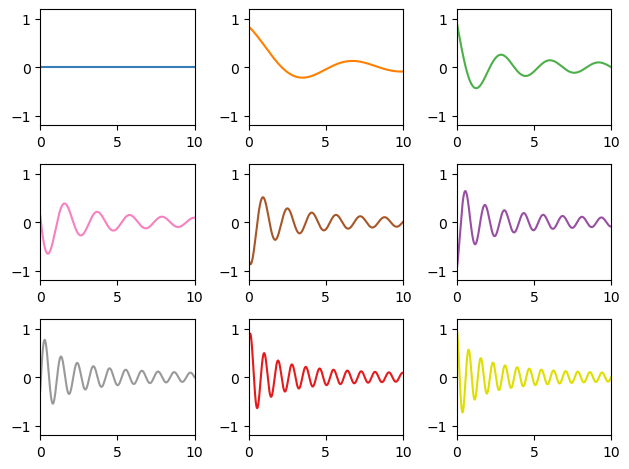

In [76]:
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']
x = np.linspace(0, 10, 1000)
for j in range(len(colors)):
    plt.subplot(3, 3, j+1)
    plt.plot(x, np.sin(j*(x+1))/(x+1), color=colors[j])
    plt.axis((0, 10, -1.2, 1.2))

plt.tight_layout()

In [105]:
set(np.append(p._models["numerator"].data,p._models["denominator"].data))

['CO_65',
 'CO_1312',
 'CO_87',
 'CO_109',
 'CO_1110',
 'H200S2_Z3',
 'CO_10',
 'H200S3_Z3',
 'H264Q1_Z1',
 'CO_32',
 'FIR',
 'CO_43',
 'CO_1413',
 'CO_54',
 'CO_98',
 'CO_76',
 'CO_21',
 'CII_158',
 'SIII_Z3',
 'H200S2_Z1',
 'H264Q1_Z3',
 'H210S1_Z3',
 'SIII_Z1',
 'H200S3_Z1',
 'CI_609',
 'H200S1_Z1',
 'OI_145+CII_158',
 'FEII_Z3',
 'CI_370',
 'H200S0_Z3',
 'CO_1211',
 'H200S1_Z3',
 'FEII_Z1',
 'H200S0_Z1',
 'OI_63',
 'OI_145',
 'OI_63+CII_158',
 'H210S1_Z1']